In [464]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers,losses

In [465]:
url = "https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow_16k.tar.gz"

In [466]:
dataset = tf.keras.utils.get_file("stack_overflow_16k",
                                  url,
                                  untar=True,
                                  cache_dir=".",
                                  cache_subdir="")

dataset_dir = os.path.join(os.path.dirname(dataset), "stack_overflow")

In [467]:
os.listdir()

['.ipynb_checkpoints',
 'aclImdb',
 'aclImdb_v1.tar.gz',
 'auto-mpg.data',
 'Basic_Image_Classification.ipynb',
 'Basic_Text_Classification.ipynb',
 'dnn_model',
 'README.md',
 'Regression.ipynb',
 'stack_overflow_16k.tar.gz',
 'test',
 'Text_Classification.ipynb',
 'train']

In [468]:
train_dir = os.path.join("train")
os.listdir(train_dir)

['csharp', 'java', 'javascript', 'python']

In [469]:
python_file = os.path.join(train_dir, "python/1101.txt")

with open(python_file) as p:
    print(p.read())

"how to print to screen after redirect print to file, in blank? i have a code use print() to write in file:..with open('test.xml', ""w+"") as outfile:.    sys.stdout = outfile...now i want write to console after this code, how can i do this?"



In [470]:
# Creating a training set
batch_size= 32
seed= 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory("train",
                                                          batch_size= batch_size,
                                                          validation_split= 0.2,
                                                          subset= "training",
                                                          seed= seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [471]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(4):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default constru

In [472]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [473]:
# Creating a validation set
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'train',
    shuffle= False,
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [474]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'test', 
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [475]:
def custom_standardization(input_data):
    lowercase= tf.strings.lower(input_data)
    stripped_html= tf.strings.regex_replace(lowercase, "(\'div\')/{.}&\n;",' ')
    return tf.strings.regex_replace(stripped_html,
                                    '[%s]' % re.escape(string.punctuation),
                                  '')

In [476]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [477]:
# Make a text-only dataset (without labels), then call adapt

train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [478]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [479]:
# retrieve a batch (of 32 reviews and labels) from the dataset

text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of extr

In [480]:
print("5190 ---> ",vectorize_layer.get_vocabulary()[5190])
print(" 209 ---> ",vectorize_layer.get_vocabulary()[209])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

5190 --->  getdate
 209 --->  cannot
Vocabulary size: 10000


In [481]:
# TextVectorization

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [482]:
# Configure the dataset for performance

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create The Model

In [483]:
embedding_dim = 16

model = tf.keras.Sequential([layers.Embedding(max_features+1, embedding_dim),
                             layers.Dropout(0.2),
                             layers.GlobalAveragePooling1D(),
                             layers.Dropout(0.2),
                             layers.Dense(4)])

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, None, 16)          160016    
                                                                 
 dropout_24 (Dropout)        (None, None, 16)          0         
                                                                 
 global_average_pooling1d_12  (None, 16)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_25 (Dropout)        (None, 16)                0         
                                                                 
 dense_12 (Dense)            (None, 4)                 68        
                                                                 
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
_______________________________________________

In [484]:
# Loss function and optimizer

model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [485]:
# Train The Model

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40)

Epoch 1/40
200/200 [==============================] - 2s 9ms/step - loss: 1.3775 - accuracy: 0.3405 - val_loss: 1.3539 - val_accuracy: 0.5956
Epoch 2/40
200/200 [==============================] - 1s 3ms/step - loss: 1.3475 - accuracy: 0.4605 - val_loss: 1.2961 - val_accuracy: 0.7256
Epoch 3/40
200/200 [==============================] - 0s 2ms/step - loss: 1.2931 - accuracy: 0.5312 - val_loss: 1.2183 - val_accuracy: 0.7513
Epoch 4/40
200/200 [==============================] - 1s 3ms/step - loss: 1.2200 - accuracy: 0.5781 - val_loss: 1.1233 - val_accuracy: 0.7694
Epoch 5/40
200/200 [==============================] - 1s 3ms/step - loss: 1.1409 - accuracy: 0.6344 - val_loss: 1.0279 - val_accuracy: 0.8175
Epoch 6/40
200/200 [==============================] - 1s 3ms/step - loss: 1.0641 - accuracy: 0.6689 - val_loss: 0.9392 - val_accuracy: 0.8363
Epoch 7/40
200/200 [==============================] - 1s 3ms/step - loss: 0.9951 - accuracy: 0.7025 - val_loss: 0.8685 - val_accuracy: 0.8512
Epoch 

In [486]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 5s 21ms/step - loss: 0.5352 - accuracy: 0.8010
Loss:  0.5351558327674866
Accuracy:  0.8009999990463257


In [487]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

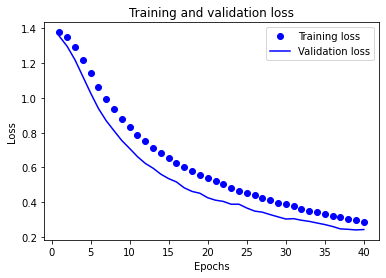

In [488]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

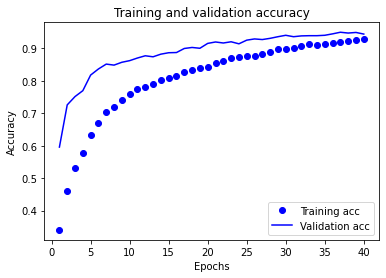

In [489]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# Export Model

In [490]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('relu')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 2s 6ms/step - loss: 0.5695 - accuracy: 0.8010
0.8009999990463257


# Inference On New Data

In [491]:
examples = [
    "Like strings (and all other built-in sequence types), lists can be indexed and sliced",
    "An array is a container object that holds a fixed number of values of a single type.",
    "To define a function, you must use the function keyword, followed by a name, followed by parentheses"
]

In [492]:
export_model.predict(examples)

array([[0.1123006 , 0.        , 0.        , 0.23612867],
       [0.05752317, 0.03336529, 0.75981146, 0.        ],
       [0.03713671, 0.        , 1.4660606 , 0.        ]], dtype=float32)